In [158]:
# libraries
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
     
from cleaning import load_and_clean

In [159]:
## clean table
## load data
data = pd.read_csv('data/diabetic_data.csv')

data_clean = data.drop([
        "metformin", "repaglinide", "nateglinide", "chlorpropamide", 
        "glimepiride", "acetohexamide", "glipizide", "glyburide", 
        "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", 
        "miglitol", "troglitazone", "tolazamide", "examide", 
        "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", 
        "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"
    ], axis = 1)

# clean data
cleaned_df = load_and_clean(data_clean)

## set features
variables = ['age', 'discharge_disposition_id', 'num_medications', 'num_lab_procedures', 'number_inpatient', 'encoded_diabetesMed', 'readmit30']
features = ['age', 'time_in_hospital', 'discharge_disposition_id', 'num_procedures', 'number_inpatient', 'female']

## select for features and outcome
cleaned_df = cleaned_df[variables]

In [160]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [161]:
neg, pos = np.bincount(cleaned_df['readmit30'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 97719
    Positive: 10775 (11.03% of total)



In [162]:
# split into train , test
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('readmit30')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('readmit30')).reshape(-1, 1)
test_labels = np.array(test_df.pop('readmit30')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.1109
Average class probability in validation set: 0.1115
Average class probability in test set:       0.1072


In [163]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (62540, 1)
Validation labels shape: (15635, 1)
Test labels shape: (19544, 1)
Training features shape: (62540, 6)
Validation features shape: (15635, 6)
Test features shape: (19544, 6)


/Users/matthew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/matthew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/matthew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/matthew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

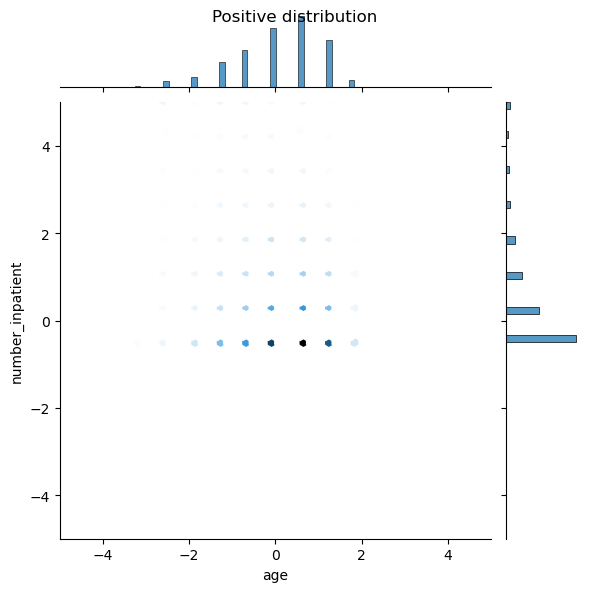

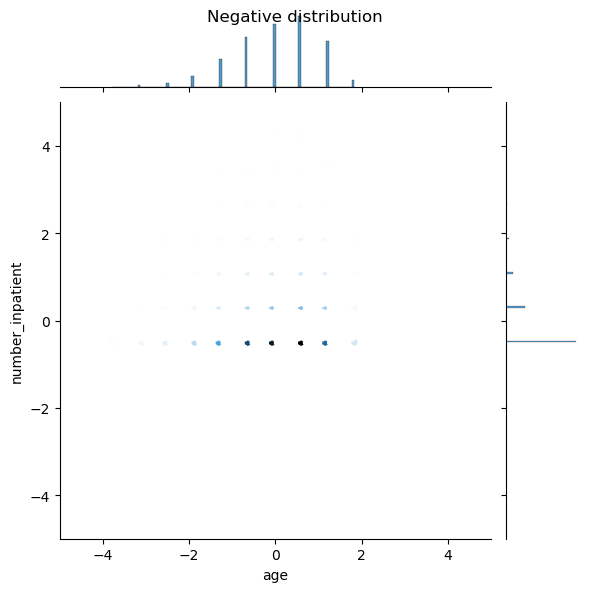

In [164]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['age'], y=pos_df['number_inpatient'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['age'], y=neg_df['number_inpatient'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [165]:
## make the model
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [166]:
EPOCHS = 100
BATCH_SIZE = 2048

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [167]:
model = make_model()
model.summary()

/Users/matthew/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129 (516.00 B)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

In [168]:
## test on first 10 rows
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[0.80338335],
       [0.8243225 ],
       [0.89397234],
       [0.84082675],
       [0.6946296 ],
       [0.6340352 ],
       [0.74102366],
       [0.8562448 ],
       [0.76266956],
       [0.8314335 ]], dtype=float32)

In [169]:
## add this check for bias - since data is unbalanced, want to minimize loss
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
initial_bias = np.log([pos/neg])
initial_bias

## try fitting a model using initial bias bias
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])


## get loss numbers
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.5949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Loss: 0.3523


In [170]:
## save model for records
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)

In [171]:
## train model with and without bias - see if the correction helped
# without bias
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

# with bias
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

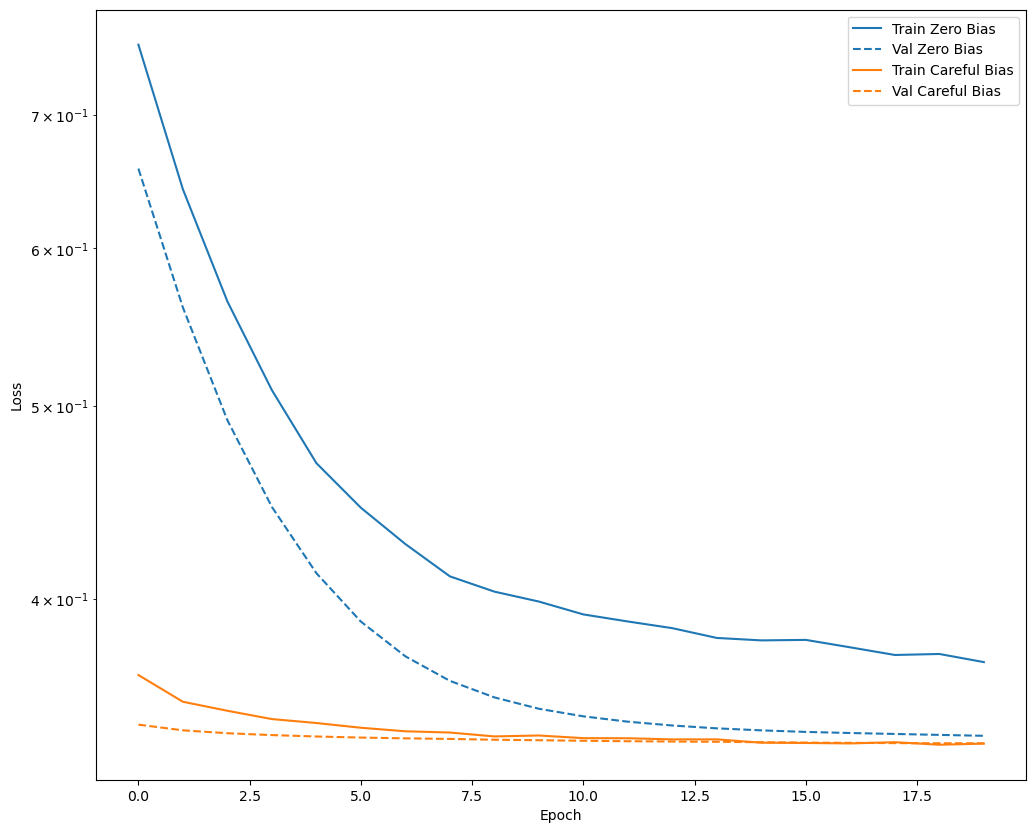

In [172]:
# plot the loss
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

## plot
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [173]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels))

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Brier score: 0.1015 - accuracy: 0.8852 - auc: 0.5622 - cross entropy: 0.3556 - fn: 5387.8125 - fp: 299.2812 - loss: 0.3652 - prc: 0.1360 - precision: 0.1899 - recall: 0.0118 - tn: 43548.3438 - tp: 68.3125 - val_Brier score: 0.0982 - val_accuracy: 0.8885 - val_auc: 0.5713 - val_cross entropy: 0.3459 - val_fn: 1743.0000 - val_fp: 0.0000e+00 - val_loss: 0.3457 - val_prc: 0.1503 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 13892.0000 - val_tp: 0.0000e+00
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Brier score: 0.1009 - accuracy: 0.8863 - auc: 0.5485 - cross entropy: 0.3561 - fn: 3690.3438 - fp: 142.0312 - loss: 0.3561 - prc: 0.1354 - precision: 0.2287 - recall: 0.0109 - tn: 29795.9375 - tp: 40.4375 - val_Brier score: 0.0977 - val_accuracy: 0.8885 - val_auc: 0.5908 - val_cross entropy: 0.3436 - val_fn: 1743.0000 - val_fp: 0.0000e+00 - val_loss: 0.3435 - val_prc: 0.1611 - val_precision: 0.0000e+00 - val_recall: 

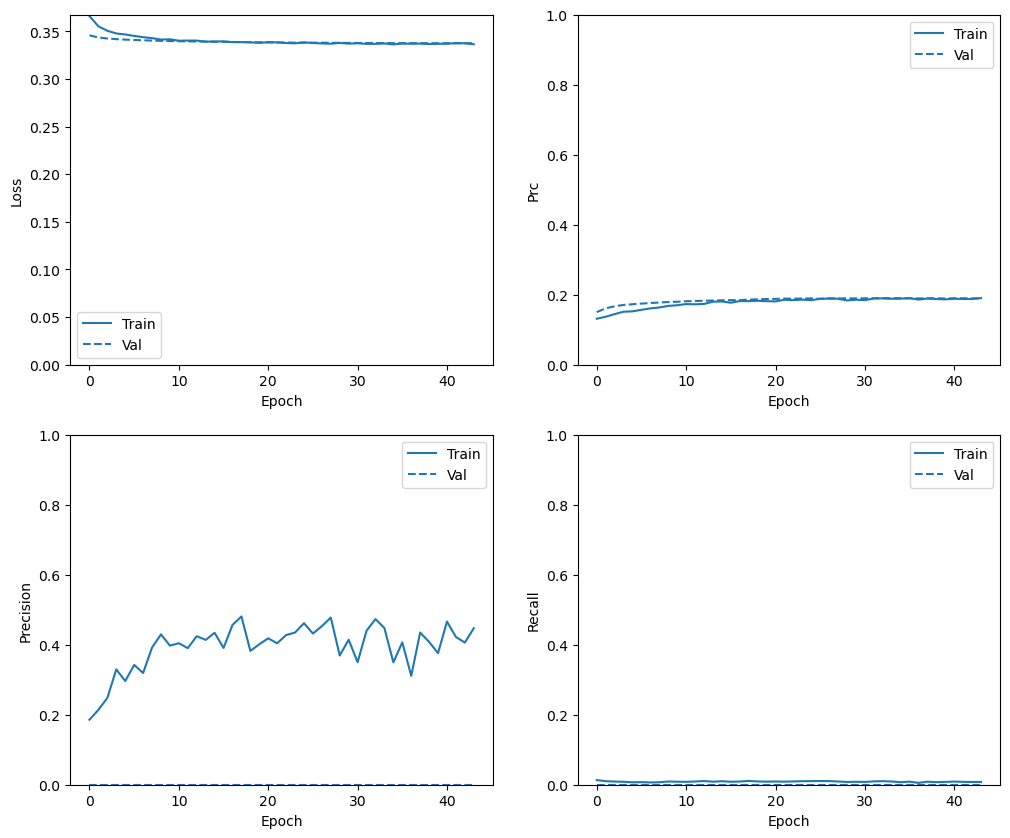

In [174]:
## plot the results of the model
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(baseline_history)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
loss :  0.32498836517333984
compile_metrics :  0.09211813658475876

Actual Non-Readmissions spotted (True Negatives):  17449
Predicted but no actual readmission (False Positives):  0
Actual readmission missed (False Negatives):  2095
Readmissions detected (True Positives):  0
Total Readmissions:  2095


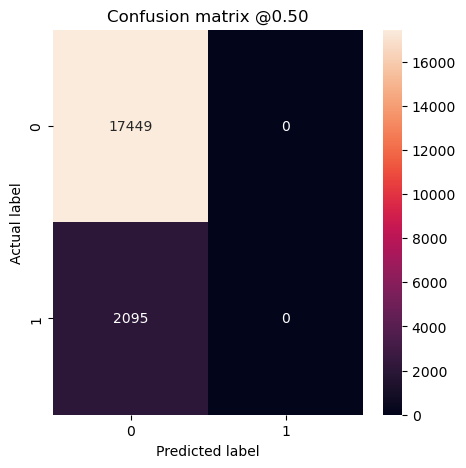

In [175]:
## create confusion matrix
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)



def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Actual Non-Readmissions spotted (True Negatives): ', cm[0][0])
  print('Predicted but no actual readmission (False Positives): ', cm[0][1])
  print('Actual readmission missed (False Negatives): ', cm[1][0])
  print('Readmissions detected (True Positives): ', cm[1][1])
  print('Total Readmissions: ', np.sum(cm[1]))

## base line results
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

Actual Non-Readmissions spotted (True Negatives):  8995
Predicted but no actual readmission (False Positives):  8454
Actual readmission missed (False Negatives):  639
Readmissions detected (True Positives):  1456
Total Readmissions:  2095
Actual Non-Readmissions spotted (True Negatives):  0
Predicted but no actual readmission (False Positives):  17449
Actual readmission missed (False Negatives):  0
Readmissions detected (True Positives):  2095
Total Readmissions:  2095


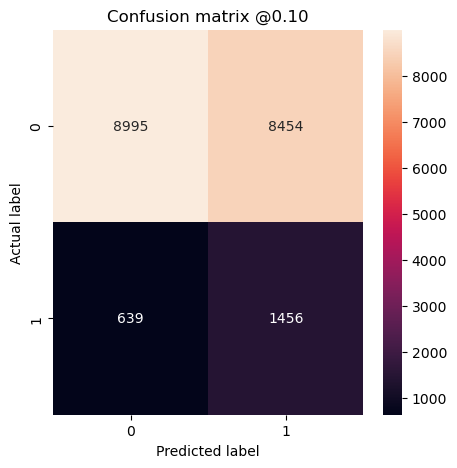

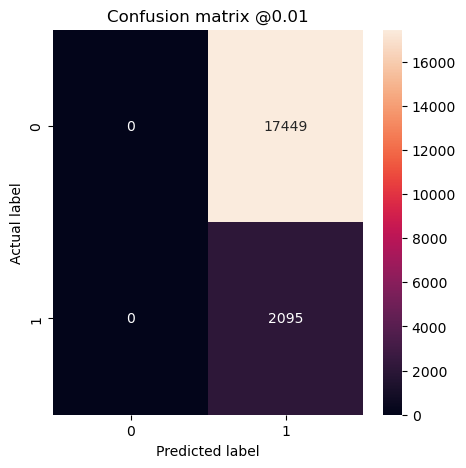

In [176]:
## try changing threshold to see if low probabilities are being given
plot_cm(test_labels, test_predictions_baseline, threshold=0.1)
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)

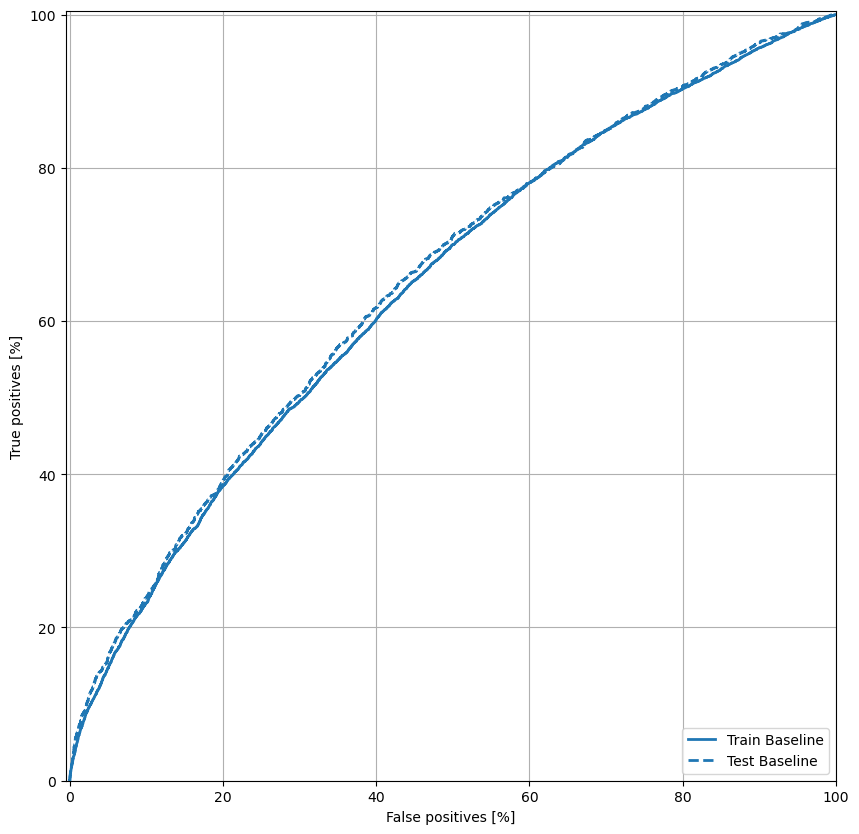

In [177]:
## plot roc curve
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

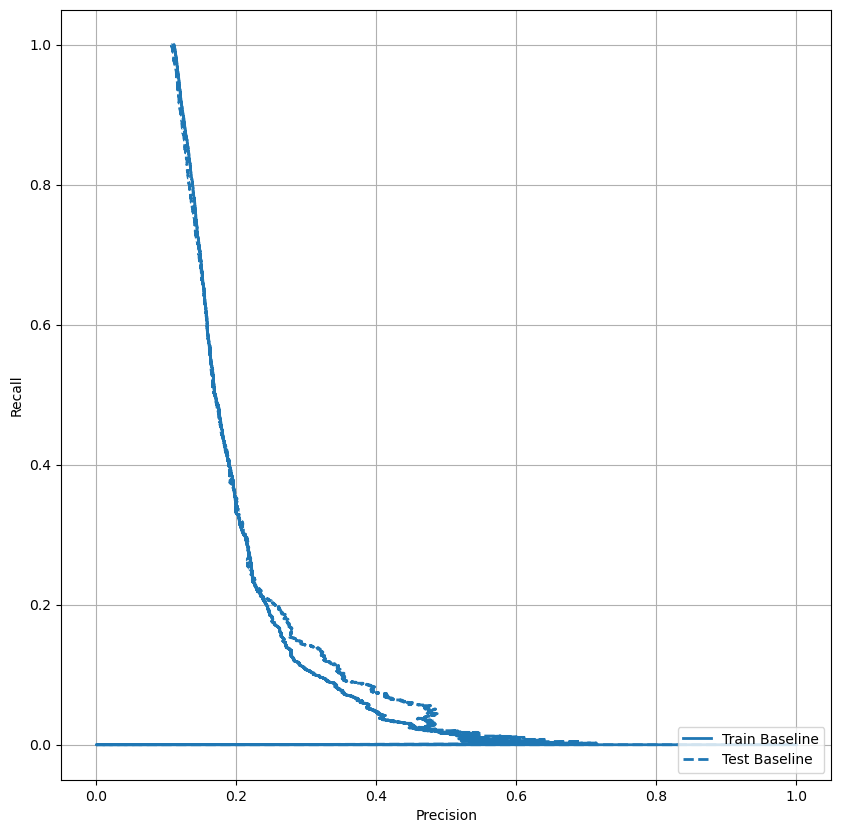

In [178]:
## precision/recall
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [179]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.56
Weight for class 1: 4.53


In [180]:
## fit model with new weights
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100


/Users/matthew/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - Brier score: 0.1020 - accuracy: 0.8841 - auc: 0.5726 - cross entropy: 0.3557 - fn: 5693.0000 - fp: 539.7188 - loss: 1.0528 - prc: 0.1388 - precision: 0.1630 - recall: 0.0167 - tn: 46869.0312 - tp: 111.0000 - val_Brier score: 0.1059 - val_accuracy: 0.8857 - val_auc: 0.5401 - val_cross entropy: 0.3702 - val_fn: 1728.0000 - val_fp: 59.0000 - val_loss: 0.3700 - val_prc: 0.1337 - val_precision: 0.2027 - val_recall: 0.0086 - val_tn: 13833.0000 - val_tp: 15.0000
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Brier score: 0.1207 - accuracy: 0.8625 - auc: 0.5255 - cross entropy: 0.4065 - fn: 3510.8438 - fp: 1192.6875 - loss: 0.9741 - prc: 0.1225 - precision: 0.1496 - recall: 0.0531 - tn: 28744.1250 - tp: 221.0938 - val_Brier score: 0.1158 - val_accuracy: 0.8770 - val_auc: 0.5414 - val_cross entropy: 0.3968 - val_fn: 1677.0000 - val_fp: 246.0000 - val_loss: 0.3966 - val_prc: 0.1370 - val_precision: 0.2115 - val_recall: 0.0379 - val_tn: 13646.0000 -

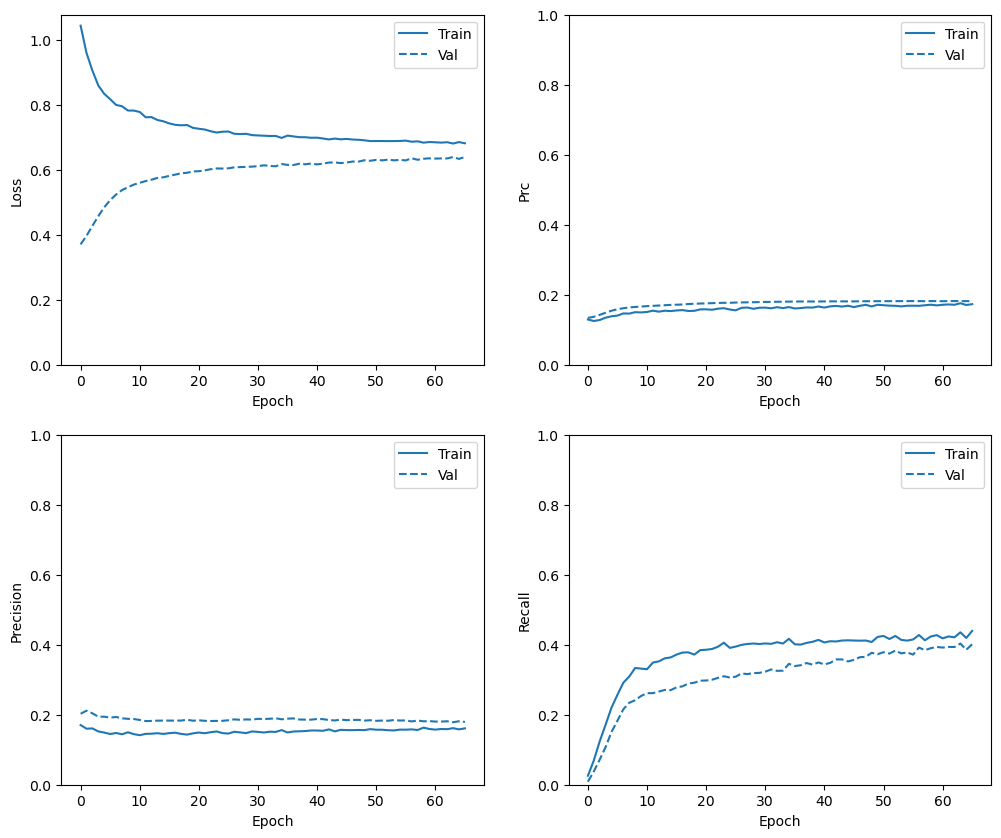

In [181]:
## check results
plot_metrics(weighted_history)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
loss :  0.6253374218940735
compile_metrics :  0.21511152386665344

Actual Non-Readmissions spotted (True Negatives):  13865
Predicted but no actual readmission (False Positives):  3584
Actual readmission missed (False Negatives):  1265
Readmissions detected (True Positives):  830
Total Readmissions:  2095


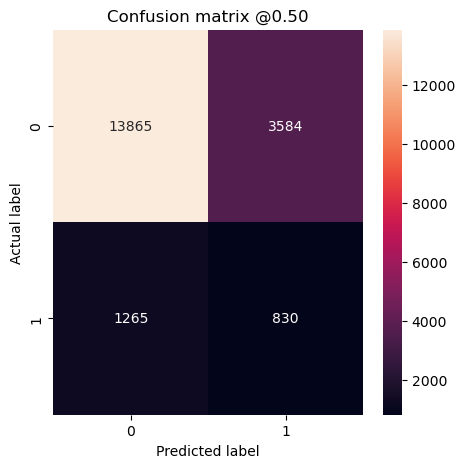

In [182]:
## confusion matrix
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

489/489 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
Best threshold: 0.1252
Precision: 0.1859
Recall: 0.3947
F1 Score: 0.2528


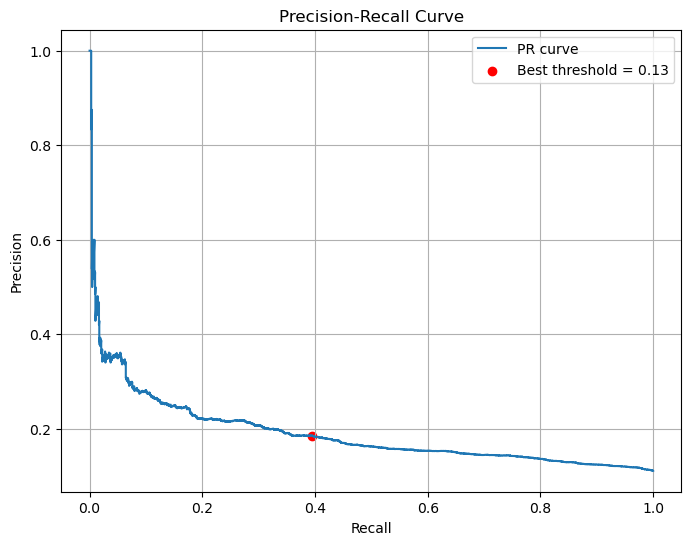

In [183]:
## try picking a 'better' threshold
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities
y_probs = model.predict(val_features).ravel()  # Probabilities for class 1
y_true = val_labels.ravel()  # True labels

# Compute PR curve
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Get threshold with highest F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.4f}")
print(f"Precision: {precision[best_idx]:.4f}")
print(f"Recall: {recall[best_idx]:.4f}")
print(f"F1 Score: {f1_scores[best_idx]:.4f}")

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best threshold = {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [187]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)

# Predict probabilities
test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)

# Set threshold
threshold = best_threshold
y_pred = (test_predictions > threshold).astype(int).flatten()

# Precision and recall for both classes
precision_pos = precision_score(test_labels, y_pred, pos_label=1)
recall_pos = recall_score(test_labels, y_pred, pos_label=1)
f1_pos = f1_score(test_labels, y_pred, pos_label=1)

precision_neg = precision_score(test_labels, y_pred, pos_label=0)
recall_neg = recall_score(test_labels, y_pred, pos_label=0)
f1_neg = f1_score(test_labels, y_pred, pos_label=0)

# Overall metrics
accuracy = accuracy_score(test_labels, y_pred)
auc = roc_auc_score(test_labels, test_predictions)

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Print results
print(f"Positive class - Precision: {precision_pos:.4f}, Recall: {recall_pos:.4f}, F1: {f1_pos:.4f}")
print(f"Negative class - Precision: {precision_neg:.4f}, Recall: {recall_neg:.4f}, F1: {f1_neg:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
Positive class - Precision: 0.1873, Recall: 0.4138, F1: 0.2579
Negative class - Precision: 0.9177, Recall: 0.7844, F1: 0.8458
Overall Accuracy: 0.7447
AUC: 0.6509
Confusion Matrix:
[[13687  3762]
 [ 1228   867]]


ExactExplainer explainer: 19545it [00:27, 444.70it/s]                           


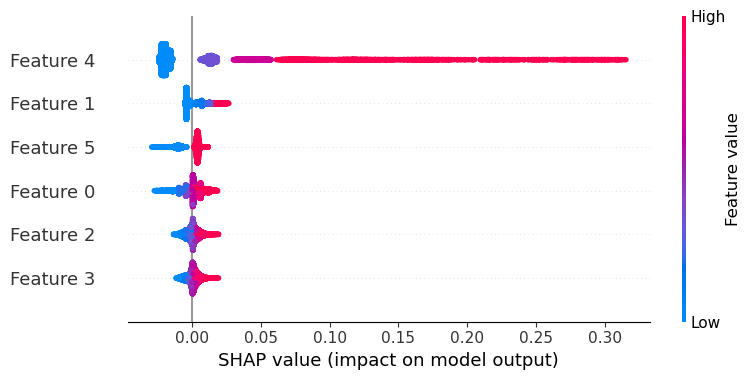

In [186]:
## variable importance
import shap

explainer = shap.Explainer(model, test_features)
shap_values = explainer(test_features)

# Plot summary
shap.summary_plot(shap_values, test_features)


The code below looks at oversampling the positive class to improve the model. The above model had the best success from my attempts.

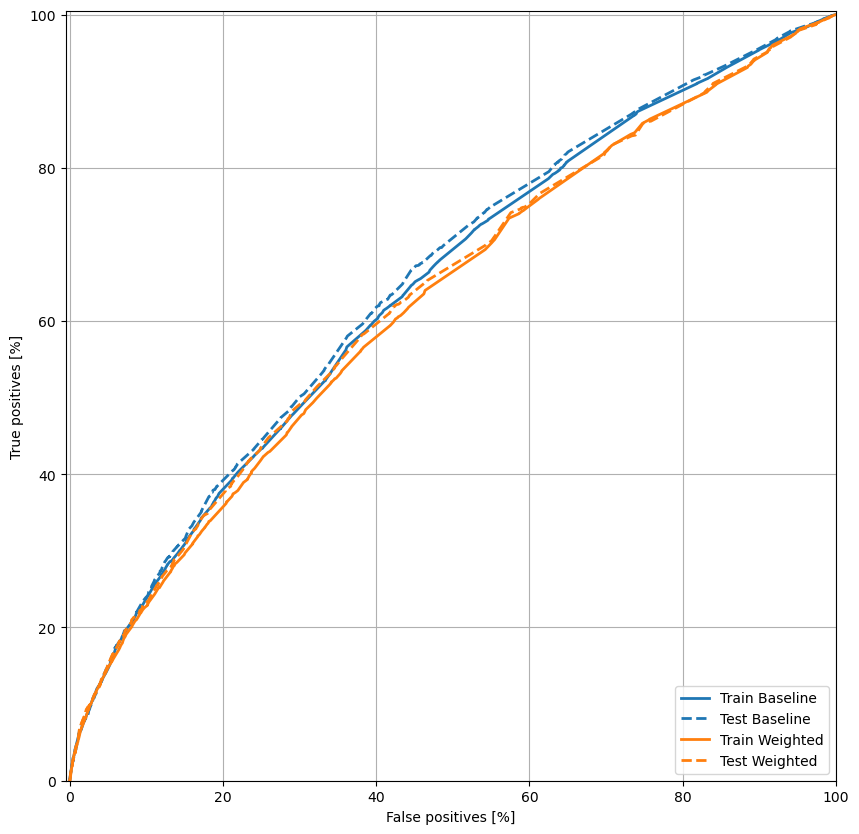

In [ ]:
## plot new ROC
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

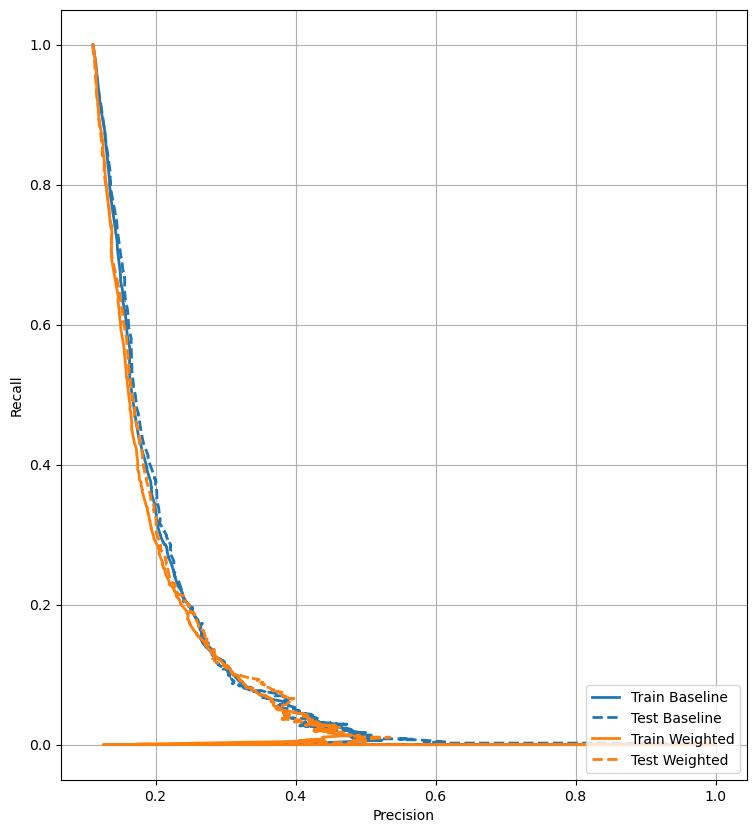

In [ ]:
## prc
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [ ]:
## attempt to oversample
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

## tf.data method
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

resampled_steps_per_epoch = int(np.ceil(2.0*neg/BATCH_SIZE))
resampled_steps_per_epoch


85

In [ ]:
## train model on oversampled
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping()],
    validation_data=val_ds)

Epoch 1/100


/Users/matthew/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - Brier score: 0.2463 - accuracy: 0.5915 - auc: 0.5687 - cross entropy: 0.6929 - fn: 27074.9531 - fp: 19007.0938 - loss: 0.7266 - prc: 0.4738 - precision: 0.4811 - recall: 0.3965 - tn: 42960.0000 - tp: 19566.1387 - val_Brier score: 0.2369 - val_accuracy: 0.6635 - val_auc: 0.6104 - val_cross entropy: 0.6672 - val_fn: 876.0000 - val_fp: 4385.0000 - val_loss: 0.6671 - val_prc: 0.1803 - val_precision: 0.1595 - val_recall: 0.4871 - val_tn: 9542.0000 - val_tp: 832.0000
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Brier score: 0.2481 - accuracy: 0.5500 - auc: 0.5741 - cross entropy: 0.6911 - fn: 19797.0820 - fp: 20138.8945 - loss: 0.6911 - prc: 0.5886 - precision: 0.5530 - recall: 0.5539 - tn: 24167.6855 - tp: 24960.5234 - val_Brier score: 0.2392 - val_accuracy: 0.6468 - val_auc: 0.6277 - val_cross entropy: 0.6724 - val_fn: 812.0000 - val_fp: 4710.0000 - val_loss: 0.6724 - val_prc: 0.1885 - val_precision: 0.1598 - val_recall: 0.5246 - val_tn: 9

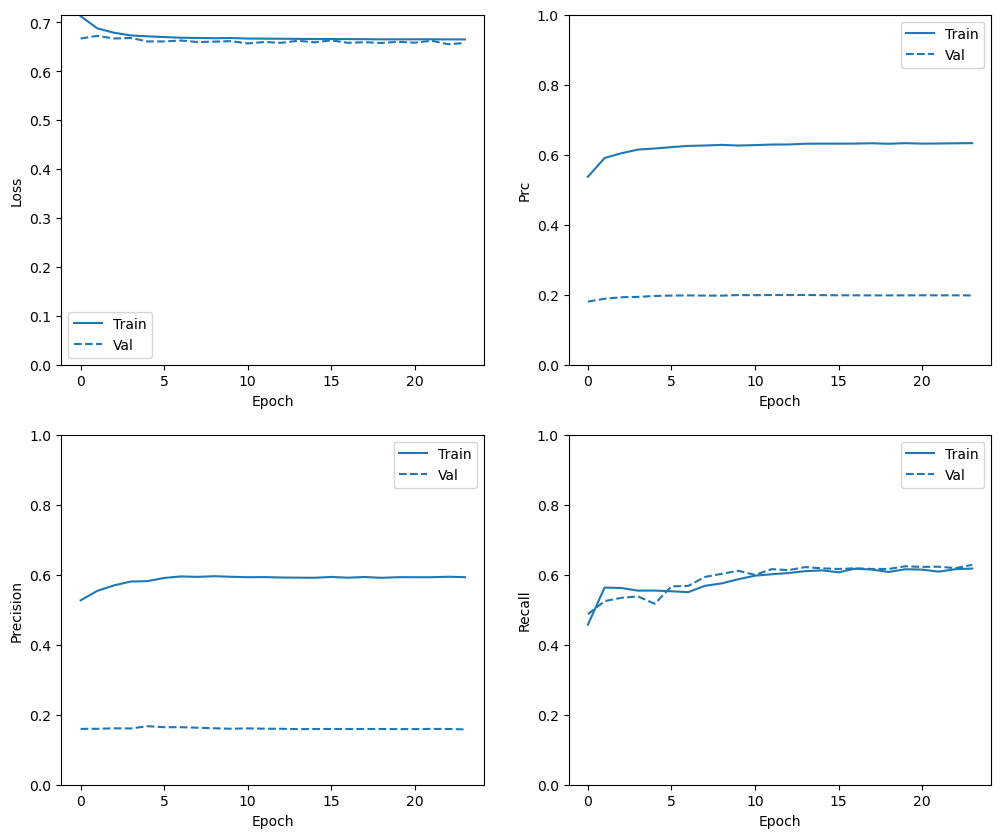

In [ ]:
plot_metrics(resampled_history)

In [ ]:
## train again
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_ds))

Epoch 1/1000


/Users/matthew/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - Brier score: 0.2507 - accuracy: 0.5545 - auc: 0.5184 - cross entropy: 0.7022 - fn: 7885.1431 - fp: 9212.3330 - loss: 0.7420 - prc: 0.3577 - precision: 0.3338 - recall: 0.3985 - tn: 15944.7617 - tp: 5023.2383 - val_Brier score: 0.2131 - val_accuracy: 0.7506 - val_auc: 0.5733 - val_cross entropy: 0.6164 - val_fn: 1181.0000 - val_fp: 2718.0000 - val_loss: 0.6163 - val_prc: 0.1581 - val_precision: 0.1624 - val_recall: 0.3085 - val_tn: 11209.0000 - val_tp: 527.0000
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - Brier score: 0.2585 - accuracy: 0.5368 - auc: 0.5478 - cross entropy: 0.7175 - fn: 6300.0000 - fp: 4132.5713 - loss: 0.7175 - prc: 0.5538 - precision: 0.5440 - recall: 0.4372 - tn: 7066.3335 - tp: 4931.5713 - val_Brier score: 0.2263 - val_accuracy: 0.6996 - val_auc: 0.5926 - val_cross entropy: 0.6442 - val_fn: 1005.0000 - val_fp: 3691.0000 - val_loss: 0.6441 - val_prc: 0.1688 - val_precision: 0.1600 - val_recall: 0.4116 - val_tn: 1023

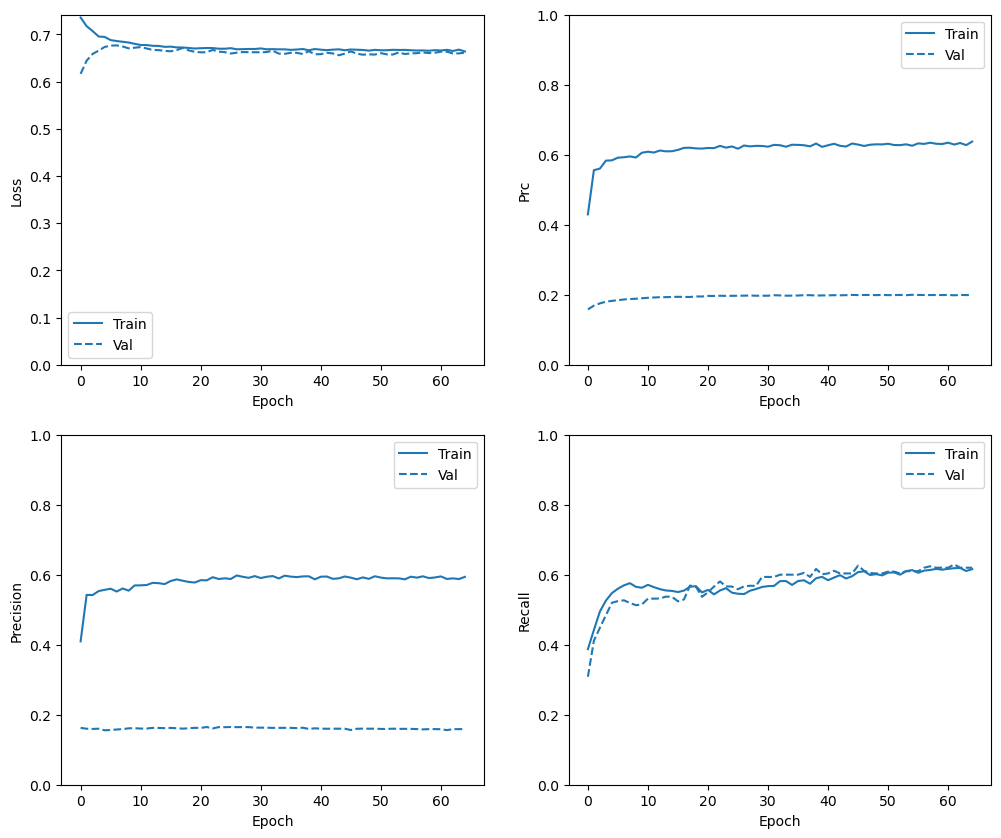

In [ ]:
## plot roc results
plot_metrics(resampled_history)

In [184]:
### get metrics for both positive and negative classes
test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)

## set prob threshold
threshold = best_threshold
y_pred = (test_predictions > threshold).astype(int).flatten()


from sklearn.metrics import precision_score, recall_score

# Precision and recall for the positive class (label=1)
precision_pos = precision_score(test_labels, y_pred, pos_label=1)
recall_pos = recall_score(test_labels, y_pred, pos_label=1)

# Precision and recall for the negative class (label=0)
precision_neg = precision_score(test_labels, y_pred, pos_label=0)
recall_neg = recall_score(test_labels, y_pred, pos_label=0)

print(f"Positive class - Precision: {precision_pos:.4f}, Recall: {recall_pos:.4f}")
print(f"Negative class - Precision: {precision_neg:.4f}, Recall: {recall_neg:.4f}")


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:")
print(cm)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
Positive class - Precision: 0.1873, Recall: 0.4138
Negative class - Precision: 0.9177, Recall: 0.7844
Confusion Matrix:
[[13687  3762]
 [ 1228   867]]


ExactExplainer explainer: 19545it [00:23, 466.21it/s]                           


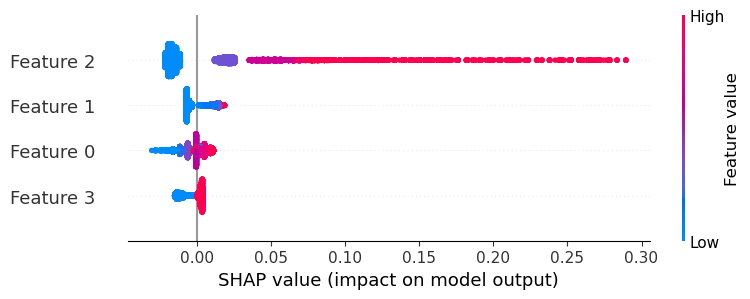

In [ ]:
import shap

explainer = shap.Explainer(model, test_features)
shap_values = explainer(test_features)

# Plot summary
shap.summary_plot(shap_values, test_features)
